# Smart Study Coach — Data Exploration, Cleaning & Recommendation

Inhoud:
1. **Ruwe Analyse** — korte analyse van de ruwe data, counts (unique tags, locations), en error rate per kolom.
2. **Cleaning & Preprocessing** — the cleaning pipeline with explanations and functions. Produces a cleaned CSV.
3. **Clean Analyse** — analyse van de schoonen data, counts (unique tags, locations), en error rate per kolom.
4. **NLP & Recommendation Engine** — text cleaning, TF-IDF vectorization, cosine similarity and a `recommend()` helper.




## Part 1 — Ruwe Analyse
We beginnen met het lade van de dataset en dan korte analyse :
- aantal unique tags (module_tags)
- aantal modules per locatie `location`
- kolom counts of empty / weird / ntb values (pre-cleaning)


In [13]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Load dataset
raw_path = "Uitgebreide_VKM_dataset.csv"
df_raw = pd.read_csv(raw_path)
print(f"Loaded dataset with {len(df_raw)} rows and {len(df_raw.columns)} columns")

# Setup Stopwords for Tags (Dutch + English)
stop_words = set(stopwords.words('english')) | set(stopwords.words('dutch'))
# Add specific noise words if necessary
extra_noise = {"ntb", "nan", "null", "none", "'", "['", "']"} 
stop_words.update(extra_noise)

Loaded dataset with 211 rows and 20 columns


Column analysis (pre-cleaning):


,column,empty_values,empty_%,weird_values,weird_%,ntb,ntb_%,general_error_total,general_error_%
12,Blauw,209,99.05,0,0.00,0,0.00,209,99.05
13,Geel,209,99.05,0,0.00,0,0.00,209,99.05
11,Groen,209,99.05,0,0.00,0,0.00,209,99.05
10,Rood,209,99.05,0,0.00,0,0.00,209,99.05
9,learningoutcomes,5,2.37,33,15.64,26,12.32,64,30.33
2,shortdescription,20,9.48,0,0.00,10,4.74,30,14.22
14,module_tags,0,0.00,10,4.74,0,0.00,10,4.74
3,description,0,0.00,6,2.84,2,0.95,8,3.79
4,content,0,0.00,6,2.84,2,0.95,8,3.79
1,name,0,0.00,0,0.00,0,0.00,0,0.00


Generating Pre-Cleaning Visualizations...


C:\Users\Storm\AppData\Local\Temp\ipykernel_23504\3042783596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loc_counts.values, y=loc_counts.index, ax=axes[0], palette="viridis")
C:\Users\Storm\AppData\Local\Temp\ipykernel_23504\3042783596.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Tag', data=tags_df, ax=axes[1], palette="magma")


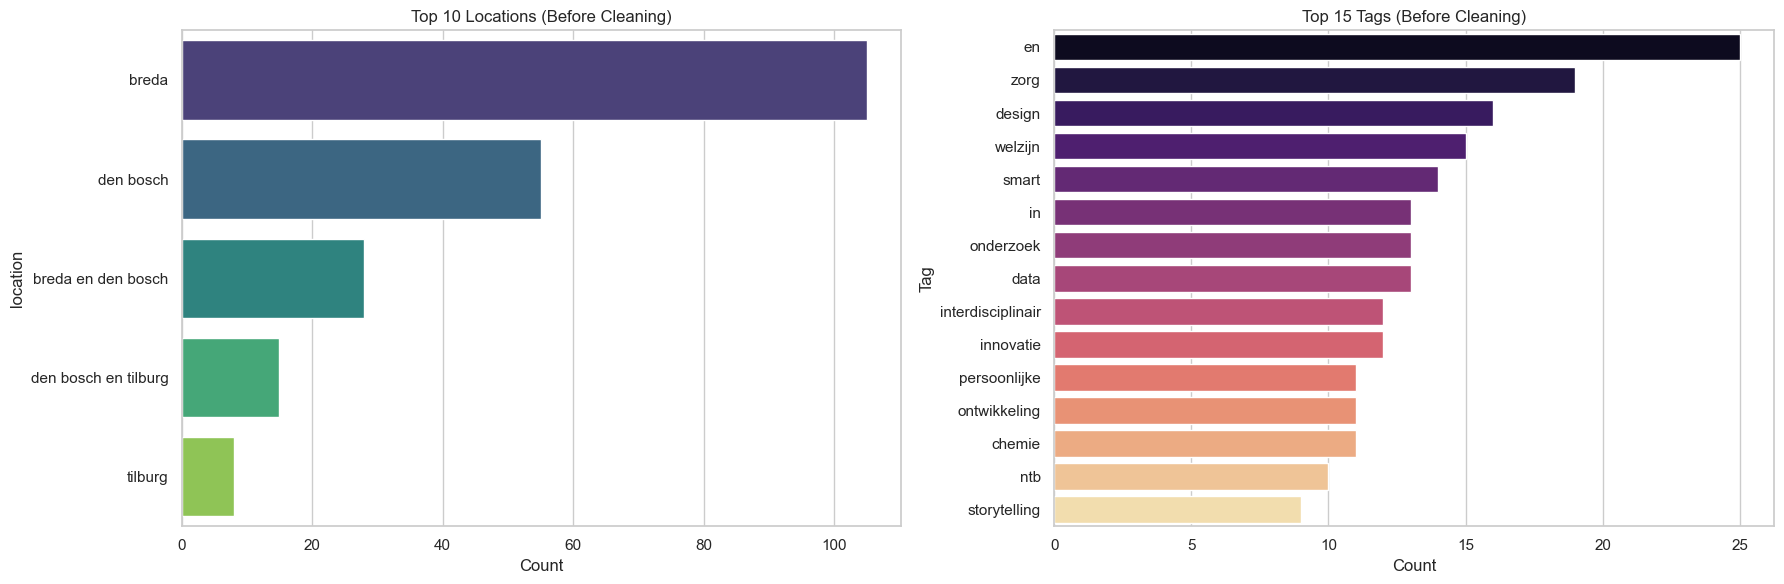

In [14]:
empty_values = ["", "nan", "none", "null", "[]"]
weird_values = [
    "nvt", "volgt", "nader te bepalen", "nog niet bekend",
    "nadert te bepalen", "nog te formuleren", "tbd", "n.n.b.", "navragen", "['ntb']"
]

def is_empty(value):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return True
    if isinstance(value, str) and value.strip() == "":
        return True
    return False

def is_weird(value):
    if not isinstance(value, str):
        return False
    val = value.lower().strip()
    return any(w in val for w in weird_values)

def is_ntb(value):
    return isinstance(value, str) and value.strip().lower() == "ntb"

def analyze_dataframe_simple(df_in):
    analysis = []
    for col in df_in.columns:
        total = len(df_in[col])
        empty_count = df_in[col].apply(is_empty).sum()
        weird_count = df_in[col].apply(is_weird).sum()
        ntb_count = df_in[col].apply(is_ntb).sum()
        general_error_count = empty_count + weird_count + ntb_count
        general_error_percent = round((general_error_count / total) * 100, 2)
        analysis.append({
            "column": col,
            "empty_values": int(empty_count),
            "empty_%": round((empty_count / total) * 100, 2),
            "weird_values": int(weird_count),
            "weird_%": round((weird_count / total) * 100, 2),
            "ntb": int(ntb_count),
            "ntb_%": round((ntb_count / total) * 100, 2),
            "general_error_total": int(general_error_count),
            "general_error_%": general_error_percent
        })
    analysis_df = pd.DataFrame(analysis).sort_values(by="general_error_%", ascending=False)
    return analysis_df

print("Column analysis (pre-cleaning):")
col_analysis_pre = analyze_dataframe_simple(df_raw)
display(col_analysis_pre)

def visualize_data(df_in, title_stage="Pre-Cleaning"):
    """
    Generates bar charts for Locations and Top Tags.
    """
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # --- 1. Location Analysis ---
    if 'location' in df_in.columns:
        loc_counts = df_in['location'].fillna('ntb').astype(str).str.lower().value_counts().head(10)
        sns.barplot(x=loc_counts.values, y=loc_counts.index, ax=axes[0], palette="viridis")
        axes[0].set_title(f"Top 10 Locations ({title_stage})")
        axes[0].set_xlabel("Count")
    
    # --- 2. Tag Analysis ---
    if 'module_tags' in df_in.columns:
        tags_series = df_in['module_tags'].fillna('')
        all_tags = []
        
        for t in tags_series.astype(str):
            # Clean string representation of list to actual words
            # Remove brackets, quotes, and split by comma
            cleaned = re.sub(r"[\[\]']", "", t) 
            parts = cleaned.split(',')
            for p in parts:
                p = p.strip().lower()
                # Basic filtering for the plot (ignoring raw empty strings)
                if p and len(p) > 1:
                    all_tags.append(p)
                    
        # Count and plot
        tag_counts = Counter(all_tags).most_common(15)
        if tag_counts:
            tags_df = pd.DataFrame(tag_counts, columns=['Tag', 'Count'])
            sns.barplot(x='Count', y='Tag', data=tags_df, ax=axes[1], palette="magma")
            axes[1].set_title(f"Top 15 Tags ({title_stage})")
        else:
            axes[1].text(0.5, 0.5, "No Tags Found", ha='center')
            
    plt.tight_layout()
    plt.show()

# Run Visualization on Raw Data
print("Generating Pre-Cleaning Visualizations...")
visualize_data(df_raw, title_stage="Before Cleaning")



## Conclusie
In de tags staat nog veel leeg of stopwoorden deze moeten eruit. Ook is er nog veel noise data in de shortdescription, description en content. deze moeten gevuld worden.

---
## Part 2 — Cleaning & Preprocessing
We perform the cleaning steps with explanations. The strategy is:
1. Drop irrelevant columns (colors) if present.
2. Normalize values to string, lowercase and trim.
3. Replace literal empty indicators with `ntb` (Not To Be Determined).
4. Apply a safe regex replacement for known weird phrases (only if cell content exactly matches one of them).
5. Smart-fill `shortdescription` from `description` and `content` where available.


Removing stopwords from module_tags...
Filling shortdescription using description/content where needed...

Analysis after cleaning:


,column,empty_values,empty_%,weird_values,weird_%,ntb,ntb_%,general_error_total,general_error_%
9,learningoutcomes,0,0.0,2,0.95,62,29.38,64,30.33
10,module_tags,0,0.0,0,0.00,30,14.22,30,14.22
3,description,0,0.0,4,1.90,4,1.90,8,3.79
4,content,0,0.0,4,1.90,4,1.90,8,3.79
2,shortdescription,0,0.0,2,0.95,2,0.95,4,1.90
5,studycredit,0,0.0,0,0.00,0,0.00,0,0.00
0,id,0,0.0,0,0.00,0,0.00,0,0.00
1,name,0,0.0,0,0.00,0,0.00,0,0.00
7,contact_id,0,0.0,0,0.00,0,0.00,0,0.00
6,location,0,0.0,0,0.00,0,0.00,0,0.00


Generating Post-Cleaning Visualizations...


C:\Users\Storm\AppData\Local\Temp\ipykernel_23504\3042783596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loc_counts.values, y=loc_counts.index, ax=axes[0], palette="viridis")
C:\Users\Storm\AppData\Local\Temp\ipykernel_23504\3042783596.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Tag', data=tags_df, ax=axes[1], palette="magma")


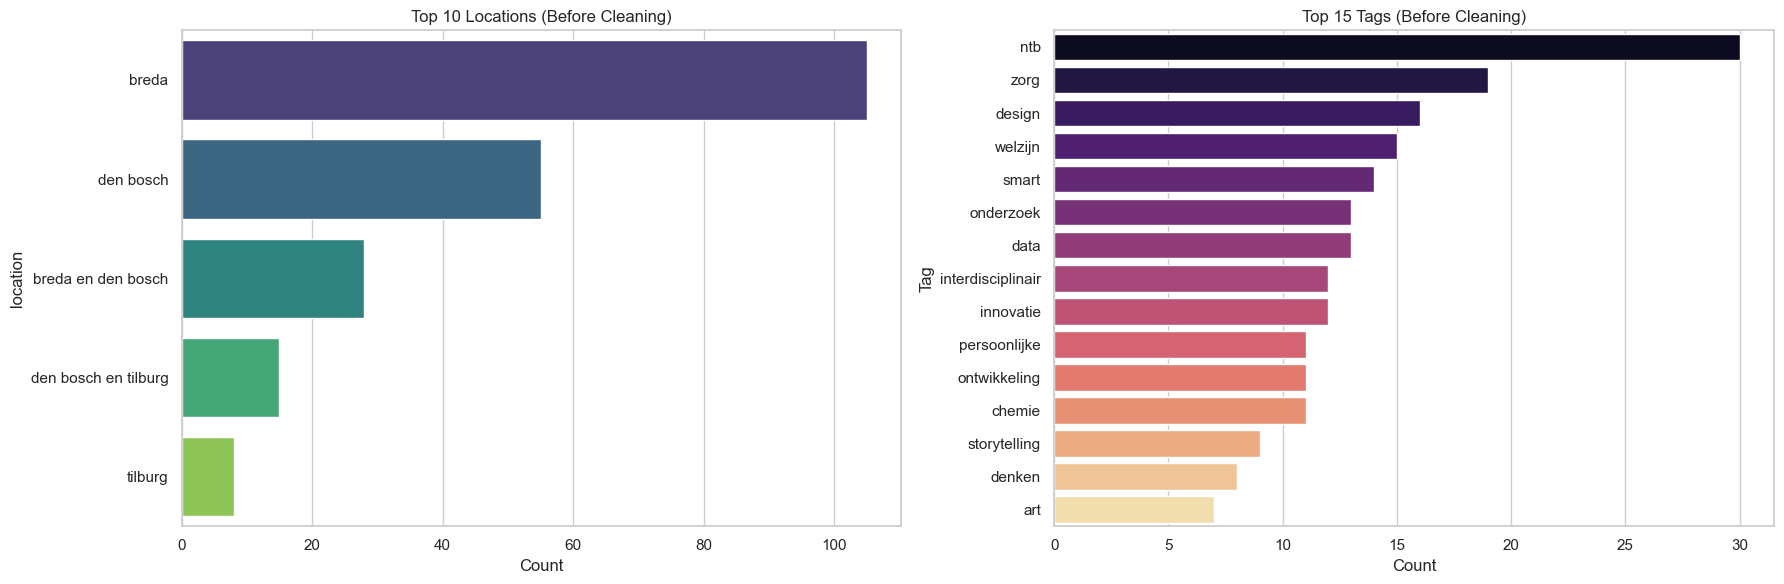

Cleaned file written to: Uitgebreide_VKM_dataset_zonder_weird_data.csv


In [15]:
df = df_raw.copy()
cols_to_drop = ["Rood", "Groen", "Blauw", "Geel"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Convert to string (safe for TF-IDF later) and normalize
df = df.fillna('')
for col in df.columns:
    # Cast to string for consistent processing
    df[col] = df[col].astype(str)
    df[col] = df[col].str.lower().str.strip()

# Replace explicit empty-like strings with 'ntb'
for val in empty_values:
    df.replace(val, 'ntb', inplace=True)

# Safe regex for weird_values: only replace if the entire cell equals the weird phrase
safe_pattern = r'^\s*(' + '|'.join([re.escape(v) for v in weird_values]) + r')\s*$'
for col in df.columns:
    df[col] = df[col].replace(to_replace=safe_pattern, value='ntb', regex=True)

# Specific Tag Cleaning (Stopword Removal)
def clean_tags_column(tag_string):
    if tag_string == 'ntb': return 'ntb'
    
    # 1. Remove list characters like [ ] ' "
    clean_str = re.sub(r"[\[\]'\"]", "", tag_string)
    
    # 2. Split by comma
    tags = clean_str.split(',')
    
    valid_tags = []
    for tag in tags:
        tag = tag.strip().lower()
        # 3. Filter: Must not be a stopword, must be > 1 char, must not be numeric
        if tag and tag not in stop_words and len(tag) > 1 and not tag.isdigit():
            valid_tags.append(tag)
            
    # Return as a clean comma-separated string (easier for reading) 
    # or keep as list string if preferred. Here we join them.
    return ", ".join(valid_tags) if valid_tags else "ntb"

print("Removing stopwords from module_tags...")
df['module_tags'] = df['module_tags'].apply(clean_tags_column)

# Smart fill for shortdescription
def fill_short_smart(row):
    short = row.get('shortdescription', 'ntb')
    if short and short != 'ntb':
        return short
    desc = row.get('description', 'ntb')
    content = row.get('content', 'ntb')
    valid_desc = desc and desc != 'ntb'
    valid_content = content and content != 'ntb'
    if valid_desc and valid_content:
        if desc == content:
            return desc
        return f"{desc} {content}"
    if valid_desc:
        return desc
    if valid_content:
        return content
    return 'ntb'

if 'shortdescription' in df.columns:
    print("Filling shortdescription using description/content where needed...")
    df['shortdescription'] = df.apply(fill_short_smart, axis=1)
else:
    print("No shortdescription column found; skipping smart fill.")

print('\nAnalysis after cleaning:')
col_analysis_post = analyze_dataframe_simple(df)
display(col_analysis_post)

print("Generating Post-Cleaning Visualizations...")
visualize_data(df, title_stage="Before Cleaning")


# Save cleaned file
out_path = 'Uitgebreide_VKM_dataset_zonder_weird_data.csv'
df.to_csv(out_path, index=False)
print(f"Cleaned file written to: {out_path}")


## Conclusie
Na het opschonen en filteren zijn er geen stopworden meer in de tags. en ook de vertaling is duidelijk te zien aangezien tags zoals onderzoek nu vaker voor komen.

---
## Part 3 — NLP & Recommendation Engine
We clean the text for NLP, vectorize using TF-IDF and compute cosine similarity. Explanations follow the cells.


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Ensure NLTK resources are available (the notebook will attempt to download if missing)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer()
    nltk.data.find('corpora/wordnet')
except Exception:
    nltk.download('wordnet')

# Prepare stopwords
stop_words = set(stopwords.words('english')) | set(stopwords.words('dutch'))
lemmatizer_en = WordNetLemmatizer()
stemmer_nl = SnowballStemmer('dutch')

def detect_language(text):
    dutch_keywords = ["de","het","een","en","je","jij","wij","zijn","module","leren","opleiding"]
    english_keywords = ["the","a","an","and","is","are","course","learn"]
    text_low = text.lower()
    nl_score = sum(1 for w in dutch_keywords if w in text_low)
    en_score = sum(1 for w in english_keywords if w in text_low)
    return 'nl' if nl_score >= en_score else 'en'

def clean_text_nlp(text):
    if not isinstance(text, str) or text.strip() == '' or text.lower() in ['ntb','tbd','nader te bepalen']:
        return 'ntb'
    text = text.lower()
    text = re.sub(r"[^a-zA-Záéíóúàèçäëïöüñ\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    lang = detect_language(text)
    words = [w for w in text.split() if w not in stop_words]
    if lang == 'nl':
        words = [stemmer_nl.stem(w) for w in words]
    else:
        words = [lemmatizer_en.lemmatize(w) for w in words]
    return ' '.join(words) if words else 'ntb'

print('Applying NLP cleaning to shortdescription and description...')
df['shortdescription'] = df['shortdescription'].apply(clean_text_nlp) if 'shortdescription' in df.columns else ''
df['description'] = df['description'].apply(clean_text_nlp) if 'description' in df.columns else ''

for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.lower()

df['combined_text'] = (
    df.get('name', pd.Series(['']*len(df))).astype(str) + ' ' +
    df.get('shortdescription', pd.Series(['']*len(df))).astype(str) + ' ' +
    df.get('module_tags', pd.Series(['']*len(df))).astype(str) + ' ' +
    df.get('location', pd.Series(['']*len(df))).astype(str)
)

combined_stopwords = list(set(stopwords.words('dutch') + stopwords.words('english')))
vectorizer = TfidfVectorizer(stop_words=combined_stopwords, min_df=1)
matrix = vectorizer.fit_transform(df['combined_text'])
print(f"TF-IDF matrix shape: {matrix.shape}")
similarities = cosine_similarity(matrix)
similarity_df = pd.DataFrame(similarities, index=df.get('name', pd.Series(range(len(df)))), columns=df.get('name', pd.Series(range(len(df)))))

def recommend(module_name, similarity_df, top_n=5):
    if module_name not in similarity_df.index:
        print('Module not found. Showing top items from dataset index:')
        print(list(similarity_df.index)[:10])
        return []
    recs = similarity_df.loc[module_name].sort_values(ascending=False)[1:top_n+1]
    results = [(name, float(score)) for name, score in recs.items()]
    print(f"Recommendations for '{module_name}':")
    for name, score in results:
        print(f"- {name} (score={score:.3f})")
    return results

# Example
example_name = df['name'].iloc[0] if 'name' in df.columns else None
if example_name is not None:
    recommend(example_name, similarity_df)
else:
    print('No name column found to demonstrate recommendations')


Applying NLP cleaning to shortdescription and description...
TF-IDF matrix shape: (211, 1614)
Recommendations for 'kennismaking met psychologie':
- minor forensisch onderzoek in de rechtbank- (if/ka) (score=0.099)
- de stem van je geweten. ga opzoek naar jouw moreel kompas. (score=0.039)
- tutorial club (score=0.027)
- business innovation (score=0.019)
- animatie / storytelling (score=0.019)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Storm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
def create_user_profile_vector(
    favorite_tags, liked_modules, skipped_modules, df, vectorizer, combined_text_col='combined_text'
):
    """
    Creates a single vector for the user based on their input, using the existing TF-IDF Vectorizer.
    
    Args:
        favorite_tags (list): List of user's favorite tags (e.g., ['python', 'ai', 'cloud']).
        liked_modules (list): List of names of modules the user liked.
        skipped_modules (list): List of names of modules the user skipped (currently used for exclusion/filtering).
        df (pd.DataFrame): The main DataFrame containing module data.
        vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
        combined_text_col (str): The column in df that contains the pre-processed combined text.

    Returns:
        scipy.sparse.csr.csr_matrix: The TF-IDF vector for the user profile.
    """
    
    # 1. Combine positive text sources
    positive_profile_text = []
    
    # A. Add Favorite Tags (clean them first)
    cleaned_tags = [tag.lower().strip() for tag in favorite_tags if tag.strip()]
    positive_profile_text.extend(cleaned_tags)
    
    # B. Add combined_text of Liked Modules
    liked_module_names = set(liked_modules)
    
    # Find the rows for liked modules and exclude skipped ones from being liked (just in case)
    valid_liked_indices = df[df['name'].isin(liked_module_names)].index
    
    # We should filter out skipped modules just in case they're also in 'liked_modules'
    skipped_module_names = set(skipped_modules)
    
    for idx in valid_liked_indices:
        module_name = df.loc[idx, 'name']
        if module_name not in skipped_module_names:
            # Append the already combined and cleaned text
            positive_profile_text.append(df.loc[idx, combined_text_col])
    
    # The user profile is a single string of all collected content
    user_text = ' '.join(positive_profile_text)
    
    # 2. Vectorize the user's profile text using the *fitted* vectorizer
    # We pass it as a list with a single element
    user_vector = vectorizer.transform([user_text])
    
    return user_vector

def recommend_to_user(
    favorite_tags, liked_modules, skipped_modules, df, vectorizer, matrix, top_n=5
):
    """
    Generates module recommendations based on a user's explicit preferences.
    
    Args:
        favorite_tags (list): User's favorite tags.
        liked_modules (list): Names of modules the user liked.
        skipped_modules (list): Names of modules the user skipped.
        df (pd.DataFrame): The main DataFrame.
        vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
        matrix (sparse matrix): The TF-IDF matrix for all modules.
        top_n (int): Number of recommendations to return.
        
    Returns:
        list: A list of tuples (module_name, score).
    """
    # 1. Create the user vector
    user_vector = create_user_profile_vector(
        favorite_tags, liked_modules, skipped_modules, df, vectorizer
    )
    
    # 2. Compute similarity between the user vector and all module vectors
    # This returns a 1xN array of scores
    user_similarities = cosine_similarity(user_vector, matrix).flatten()
    
    # 3. Get the indices of the top N modules
    # np.argsort returns indices that would sort an array
    # [::-1] reverses the order for descending (most similar first)
    # [0:top_n] takes the top N indices
    top_indices = user_similarities.argsort()[::-1][0:top_n]
    
    results = []
    recommended_names = set()
    
    # Get the names of the modules to exclude (liked, skipped)
    exclude_names = set(liked_modules) | set(skipped_modules)
    
    print("\nUser Profile:")
    print(f"- Tags: {favorite_tags}")
    print(f"- Liked: {liked_modules}")
    print(f"- Skipped: {skipped_modules}")
    print("-" * 30)
    print(f"Top {top_n} Recommendations for User:")
    
    # We iterate through the top indices and skip any that the user has already interacted with
    # We may need to check more than top_n indices to find top_n *new* modules.
    max_search_idx = min(len(user_similarities), len(user_similarities) + 10) 
    
    for i in user_similarities.argsort()[::-1]:
        module_name = df.loc[i, 'name']
        score = user_similarities[i]
        
        # Exclude modules the user has already liked or skipped
        if module_name not in exclude_names and module_name not in recommended_names:
            recommended_names.add(module_name)
            results.append((module_name, score))
            print(f"- {module_name} (score={score:.3f})")
            
        if len(results) >= top_n:
            break
    
    if not results:
        print("Could not find any new recommendations based on the profile.")
    
    return results

# --- Demonstration of New Function ---

# 1. Get some example names from the dataset for demonstration
example_module_1 = df['name'].iloc[1] if len(df) > 1 else "Module A"
example_module_2 = df['name'].iloc[2] if len(df) > 2 else "Module B"
example_module_3 = df['name'].iloc[3] if len(df) > 3 else "Module C"
example_module_4 = df['name'].iloc[4] if len(df) > 4 else "Module D"

# 2. Define a hypothetical user's input (this is what comes from the site)
user_favorite_tags = ['data science', 'ai', 'amsterdam']
user_liked_modules = [example_module_1, example_module_2]
user_skipped_modules = [example_module_3]

# 3. Run the new user-based recommendation function
if 'name' in df.columns:
    recommend_to_user(
        favorite_tags=user_favorite_tags,
        liked_modules=user_liked_modules,
        skipped_modules=user_skipped_modules,
        df=df,
        vectorizer=vectorizer,
        matrix=matrix,
        top_n=5
    )


User Profile:
- Tags: ['data science', 'ai', 'amsterdam']
- Liked: ['learning and working abroad', 'proactieve zorgplanning']
- Skipped: ['rouw en verlies']
------------------------------
Top 5 Recommendations for User:
- acuut complexe zorg (score=0.147)
- datagedreven besluitvorming met ai (score=0.133)
- emerging technologies playground (score=0.109)
- module 2.1 oriëntatie op het beroepenveld (score=0.093)
- chemical modelling (score=0.091)


### Resultaat
- User input wordt verwerkt door verschillende data als input te vragen zoals de favoriete modules en de skipped modules. en de gelikte tags
- Recomend service geeft top 5 terug met score en bredenering.